In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
print('torch version :', torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('torch device :',device)

torch version : 1.7.1
torch device : cuda:0


In [3]:
train_data = datasets.MNIST(root='data',train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='data',train=False, transform=transforms.ToTensor(), download=True)

In [4]:
train_data.__getitem__(0)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

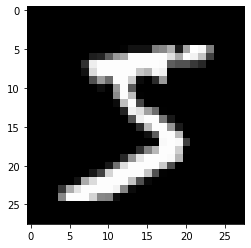

In [5]:
plt.imshow(train_data.__getitem__(0)[0].reshape(28,28),cmap='gray')
plt.show()

In [15]:
BATCH_SIZE = 256
train_iter = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=1)
test_iter = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, num_workers=1)

In [7]:
class NLP(nn.Module):
    def __init__(self, x_dim=28*28, h_dim=256, y_dim=10):
        super(NLP, self).__init__()
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.y_dim = y_dim
        self.lin_1 = nn.Linear(self.x_dim, self.h_dim)
        self.lin_2 = nn.Linear(self.h_dim, self.y_dim)
        self.init_param()
        
    def forward(self,x):
        x = self.lin_2(F.relu(self.lin_1(x)))
        return x
    
    def init_param(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        

In [22]:
model = NLP(x_dim = 28*28,h_dim = 256, y_dim=10).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)

- Parameter check

In [9]:
for name, param in model.named_parameters():
    num_param = param.detach().cpu().numpy().reshape(-1)[:3]
    print(name, num_param)

lin_1.weight [-0.01787557  0.05334545  0.03385282]
lin_1.bias [0. 0. 0.]
lin_2.weight [ 0.01404756 -0.01734875  0.14111848]
lin_2.bias [0. 0. 0.]


- data

In [26]:
def eval_func(model, data_iter, device):
    model.eval()
    with torch.no_grad():
        count_all, count = 0,0
        for batch_in, batch_label in data_iter:
            x = batch_in.view(-1,28*28).to(device)
            y = batch_label.to(device)
            y_pred = model.forward(x)
            _, y_ = torch.max(y_pred,dim=-1)
            count_all += batch_in.size(0)
            count += ((y == y_).sum().item())
    return count/count_all

In [13]:
eval_func(model, train_iter, device)

0.09815


In [16]:
eval_func(model, test_iter, device)

0.1014


통계적으로 확률적으로 높은 것들을 찾는 것이 아니라 인과관계를 찾아야 할텐데..

In [27]:
EPOCH = 10
for i in range(EPOCH):
    model.train()
    for batch_in, batch_label in train_iter:
        x = batch_in.view(-1,28*28).to(device)
        y = batch_label.to(device)
        y_pred = model.forward(x)
        loss_out = loss(y_pred,y)
        optimizer.zero_grad()
        loss_out.backward()
        optimizer.step()
        train_eval = eval_func(model, train_iter, device)
        test_eval = eval_func(model, test_iter, device)
        print(i, train_eval, test_eval, loss_out.data)

0 0.48023333333333335 0.489 tensor(1.9548, device='cuda:0')
0 0.5169833333333334 0.5241 tensor(1.8805, device='cuda:0')
0 0.5484333333333333 0.557 tensor(1.8731, device='cuda:0')
0 0.5756 0.5817 tensor(1.7486, device='cuda:0')
0 0.6016333333333334 0.6102 tensor(1.7026, device='cuda:0')
0 0.62895 0.6381 tensor(1.6661, device='cuda:0')
0 0.65345 0.6657 tensor(1.5752, device='cuda:0')
0 0.6754333333333333 0.6895 tensor(1.4961, device='cuda:0')
0 0.6960333333333333 0.7113 tensor(1.4473, device='cuda:0')
0 0.7140666666666666 0.7266 tensor(1.4037, device='cuda:0')
0 0.7306 0.7444 tensor(1.4182, device='cuda:0')
0 0.7447333333333334 0.7576 tensor(1.2577, device='cuda:0')
0 0.7562166666666666 0.7677 tensor(1.2656, device='cuda:0')
0 0.7658833333333334 0.7787 tensor(1.2507, device='cuda:0')
0 0.77405 0.7881 tensor(1.1757, device='cuda:0')
0 0.7822333333333333 0.7954 tensor(1.0904, device='cuda:0')
0 0.7888166666666667 0.8013 tensor(1.0863, device='cuda:0')
0 0.7954666666666667 0.806 tensor(1.06

0 0.9146166666666666 0.9187 tensor(0.3203, device='cuda:0')
0 0.91495 0.9177 tensor(0.3378, device='cuda:0')
0 0.9157 0.9169 tensor(0.3720, device='cuda:0')
0 0.91665 0.918 tensor(0.2938, device='cuda:0')
0 0.9173833333333333 0.9181 tensor(0.3619, device='cuda:0')
0 0.9173666666666667 0.9178 tensor(0.2967, device='cuda:0')
0 0.9173 0.9182 tensor(0.3654, device='cuda:0')
0 0.91735 0.9185 tensor(0.2881, device='cuda:0')
0 0.91745 0.9192 tensor(0.3320, device='cuda:0')
0 0.9170333333333334 0.9198 tensor(0.3287, device='cuda:0')
0 0.9176 0.9197 tensor(0.3308, device='cuda:0')
0 0.9185166666666666 0.921 tensor(0.2954, device='cuda:0')
0 0.9190666666666667 0.9223 tensor(0.3443, device='cuda:0')
0 0.9188 0.9229 tensor(0.2905, device='cuda:0')
0 0.91855 0.9221 tensor(0.2914, device='cuda:0')
0 0.9175833333333333 0.9224 tensor(0.2705, device='cuda:0')
0 0.9171666666666667 0.9227 tensor(0.3106, device='cuda:0')
0 0.9169166666666667 0.9224 tensor(0.2865, device='cuda:0')
0 0.9168 0.9228 tensor(0.

1 0.9369666666666666 0.9343 tensor(0.1924, device='cuda:0')
1 0.9368833333333333 0.9345 tensor(0.1956, device='cuda:0')
1 0.9364 0.9348 tensor(0.1872, device='cuda:0')
1 0.93675 0.9345 tensor(0.3219, device='cuda:0')
1 0.9370666666666667 0.9346 tensor(0.2151, device='cuda:0')
1 0.9372166666666667 0.9357 tensor(0.2359, device='cuda:0')
1 0.9374166666666667 0.9363 tensor(0.1889, device='cuda:0')
1 0.9376333333333333 0.9372 tensor(0.1999, device='cuda:0')
1 0.9376666666666666 0.9372 tensor(0.2734, device='cuda:0')
1 0.9374833333333333 0.9376 tensor(0.2819, device='cuda:0')
1 0.9368666666666666 0.9363 tensor(0.1903, device='cuda:0')
1 0.93645 0.9361 tensor(0.2855, device='cuda:0')
1 0.9360333333333334 0.9357 tensor(0.1889, device='cuda:0')
1 0.9364333333333333 0.9353 tensor(0.2376, device='cuda:0')
1 0.9365666666666667 0.9351 tensor(0.2817, device='cuda:0')
1 0.9372166666666667 0.9358 tensor(0.2731, device='cuda:0')
1 0.9376166666666667 0.9361 tensor(0.2592, device='cuda:0')
1 0.9374 0.935

1 0.9483666666666667 0.944 tensor(0.1486, device='cuda:0')
1 0.9481166666666667 0.9436 tensor(0.1818, device='cuda:0')
1 0.9475 0.9427 tensor(0.1066, device='cuda:0')
1 0.9477333333333333 0.9426 tensor(0.2183, device='cuda:0')
1 0.9480166666666666 0.9435 tensor(0.2336, device='cuda:0')
1 0.9482333333333334 0.944 tensor(0.2208, device='cuda:0')
1 0.9484833333333333 0.9437 tensor(0.1663, device='cuda:0')
1 0.9487333333333333 0.9437 tensor(0.2215, device='cuda:0')
1 0.9485666666666667 0.944 tensor(0.2542, device='cuda:0')
1 0.9487 0.9445 tensor(0.2636, device='cuda:0')
1 0.9482 0.9446 tensor(0.1721, device='cuda:0')
1 0.9479 0.9447 tensor(0.1983, device='cuda:0')
1 0.9475833333333333 0.9443 tensor(0.1652, device='cuda:0')
1 0.9472166666666667 0.9444 tensor(0.2335, device='cuda:0')
1 0.9470333333333333 0.9445 tensor(0.1922, device='cuda:0')
1 0.9469833333333333 0.9449 tensor(0.1009, device='cuda:0')
1 0.9467166666666667 0.945 tensor(0.1722, device='cuda:0')
1 0.9470833333333334 0.9451 tens

2 0.955 0.9519 tensor(0.1081, device='cuda:0')
2 0.9548833333333333 0.9524 tensor(0.1860, device='cuda:0')
2 0.95525 0.9523 tensor(0.2178, device='cuda:0')
2 0.9551833333333334 0.9525 tensor(0.1453, device='cuda:0')
2 0.9551 0.952 tensor(0.1680, device='cuda:0')
2 0.9548 0.9515 tensor(0.1271, device='cuda:0')
2 0.95495 0.9515 tensor(0.2031, device='cuda:0')
2 0.95545 0.9514 tensor(0.2105, device='cuda:0')
2 0.95545 0.952 tensor(0.2428, device='cuda:0')
2 0.9556166666666667 0.9523 tensor(0.2604, device='cuda:0')
2 0.9556166666666667 0.9527 tensor(0.1443, device='cuda:0')
2 0.9557833333333333 0.9524 tensor(0.1805, device='cuda:0')
2 0.9560166666666666 0.9524 tensor(0.1549, device='cuda:0')
2 0.9558333333333333 0.9523 tensor(0.1591, device='cuda:0')
2 0.9557833333333333 0.953 tensor(0.1816, device='cuda:0')
2 0.9556666666666667 0.9527 tensor(0.1498, device='cuda:0')
2 0.9562333333333334 0.9531 tensor(0.1534, device='cuda:0')
2 0.9562833333333334 0.9532 tensor(0.1950, device='cuda:0')
2 0.

3 0.9624833333333334 0.957 tensor(0.1231, device='cuda:0')
3 0.9624166666666667 0.9572 tensor(0.1326, device='cuda:0')
3 0.9622833333333334 0.9575 tensor(0.0984, device='cuda:0')
3 0.9625 0.9574 tensor(0.1289, device='cuda:0')
3 0.9621833333333333 0.9571 tensor(0.1641, device='cuda:0')
3 0.9620666666666666 0.9572 tensor(0.1414, device='cuda:0')
3 0.9620833333333333 0.9568 tensor(0.1037, device='cuda:0')
3 0.9619833333333333 0.9573 tensor(0.1444, device='cuda:0')
3 0.9618666666666666 0.9579 tensor(0.1626, device='cuda:0')
3 0.9620833333333333 0.9576 tensor(0.1398, device='cuda:0')
3 0.9621333333333333 0.9581 tensor(0.1751, device='cuda:0')
3 0.96235 0.9578 tensor(0.1065, device='cuda:0')
3 0.96255 0.9584 tensor(0.1460, device='cuda:0')
3 0.9628333333333333 0.9581 tensor(0.1762, device='cuda:0')
3 0.9629166666666666 0.9584 tensor(0.1713, device='cuda:0')
3 0.9627833333333333 0.9579 tensor(0.1427, device='cuda:0')
3 0.9628 0.9582 tensor(0.1719, device='cuda:0')
3 0.9629666666666666 0.9582

3 0.9653666666666667 0.9596 tensor(0.1635, device='cuda:0')
3 0.96575 0.9595 tensor(0.1703, device='cuda:0')
3 0.9659166666666666 0.9598 tensor(0.1546, device='cuda:0')
3 0.9659333333333333 0.9599 tensor(0.1631, device='cuda:0')
3 0.9661833333333333 0.9603 tensor(0.1534, device='cuda:0')
3 0.9664833333333334 0.9613 tensor(0.1465, device='cuda:0')
3 0.9664166666666667 0.9613 tensor(0.1035, device='cuda:0')
3 0.9667333333333333 0.9613 tensor(0.1616, device='cuda:0')
3 0.9666666666666667 0.9612 tensor(0.1252, device='cuda:0')
3 0.9669333333333333 0.9613 tensor(0.1424, device='cuda:0')
3 0.9669166666666666 0.9612 tensor(0.1388, device='cuda:0')
3 0.9670333333333333 0.9614 tensor(0.1077, device='cuda:0')
3 0.9669333333333333 0.9609 tensor(0.1598, device='cuda:0')
3 0.9669666666666666 0.9608 tensor(0.1439, device='cuda:0')
3 0.9669666666666666 0.9616 tensor(0.1313, device='cuda:0')
3 0.96705 0.9616 tensor(0.1671, device='cuda:0')
3 0.96715 0.9618 tensor(0.1347, device='cuda:0')
3 0.967333333

4 0.9694833333333334 0.9646 tensor(0.1964, device='cuda:0')
4 0.9697833333333333 0.9643 tensor(0.0693, device='cuda:0')
4 0.9699666666666666 0.9641 tensor(0.1080, device='cuda:0')
4 0.9699666666666666 0.9644 tensor(0.1257, device='cuda:0')
4 0.9699666666666666 0.9647 tensor(0.1798, device='cuda:0')
4 0.9698833333333333 0.964 tensor(0.1261, device='cuda:0')
4 0.96995 0.9647 tensor(0.1663, device='cuda:0')
4 0.9698666666666667 0.9644 tensor(0.1138, device='cuda:0')
4 0.9698333333333333 0.9639 tensor(0.1223, device='cuda:0')
4 0.9698333333333333 0.9634 tensor(0.0857, device='cuda:0')
4 0.9697 0.9634 tensor(0.1105, device='cuda:0')
4 0.9700166666666666 0.9635 tensor(0.0998, device='cuda:0')
4 0.97015 0.9636 tensor(0.1174, device='cuda:0')
4 0.9703166666666667 0.9643 tensor(0.0883, device='cuda:0')
4 0.97035 0.9641 tensor(0.0903, device='cuda:0')
4 0.97035 0.9645 tensor(0.1485, device='cuda:0')
4 0.9704333333333334 0.9646 tensor(0.1364, device='cuda:0')
4 0.9704166666666667 0.9645 tensor(0.

4 0.9724666666666667 0.9649 tensor(0.1139, device='cuda:0')
4 0.9727 0.9649 tensor(0.0773, device='cuda:0')
4 0.9727333333333333 0.9651 tensor(0.2056, device='cuda:0')
5 0.9728166666666667 0.9653 tensor(0.0786, device='cuda:0')
5 0.9731333333333333 0.966 tensor(0.0684, device='cuda:0')
5 0.9733666666666667 0.9667 tensor(0.0870, device='cuda:0')
5 0.97355 0.9665 tensor(0.1552, device='cuda:0')
5 0.9737833333333333 0.9667 tensor(0.1174, device='cuda:0')
5 0.9738166666666667 0.967 tensor(0.0800, device='cuda:0')
5 0.97375 0.9666 tensor(0.0826, device='cuda:0')
5 0.9737 0.9657 tensor(0.0600, device='cuda:0')
5 0.97335 0.9658 tensor(0.1141, device='cuda:0')
5 0.9733333333333334 0.9661 tensor(0.0782, device='cuda:0')
5 0.9731 0.9662 tensor(0.0767, device='cuda:0')
5 0.97275 0.9663 tensor(0.1097, device='cuda:0')
5 0.9728 0.9662 tensor(0.1080, device='cuda:0')
5 0.97295 0.9664 tensor(0.0940, device='cuda:0')
5 0.9733333333333334 0.9666 tensor(0.1051, device='cuda:0')
5 0.9735333333333334 0.96

KeyboardInterrupt: 